In [1]:
# following stenum et al steps to ID gait events from vertical/frontal videos 

In [2]:
import matplotlib.pyplot as plt 
import pandas as pd 
import numpy as np
from scipy.signal import find_peaks, butter, filtfilt
import os

# Gait event detection

## Frontal videos 

 Stenum et al: *Frontal Videos - We identified events of left and right gait cycles by local maxima and minima ofthe
**vertical distance** between the left and right ankle keypoints. Gait events on the left limb
were detected at positive peaks and gait events on the right limb were detected at nega-
tive peaks in trials where the participants walked away from the frontal plane camera;
and vice versa in trials where the participants walked toward the camera. In order to
unify the nomenclature ofgait events across motion capture data and sagittal and fron-
tal plane video data, we refer to the gait events ofthe frontal plane analysis as heel-
strikes.*

- limitation: gait events ID not truly "heel strikes" 

## to -do 
- For now, manually checking video length from visual annotation excel and using to convert frames to time. 
- - Need to write code to automatically make conversion. See self care selfies code?
- this script: practice on video in one direction with known 10 steps
  - identify turns and walking toward or away from camera based on height
- determine if filtering would improve accuracy?
    - can use stenum method to determine optimal filtering and movMean parameters

In [3]:
# mediapipe data frame, vertical = frontal 
input_csv = r'C:\Users\mmccu\Box\MM_Personal\5_Projects\BoveLab\3_Data_and_Code\hva_code\HomeVideoAnalysis\temp\main_branch_outputs\000_run\MM_HC_10steps_away_1_mediapipe.csv'

# video length in seconds- by visual annotation for now 
video_length_sec = 8

df_mp = pd.read_csv(input_csv, index_col = False)

df_mp.iloc[0:33, :]

,Unnamed: 0,X,Y,Z,vis,pres,frame,label
0,0,0.508954,0.077477,0.927662,0.999902,0.0,0,nose
1,1,0.487649,0.061475,0.764303,0.999905,0.0,0,left_eye_inner
2,2,0.470187,0.061335,0.764511,0.999908,0.0,0,left_eye
3,3,0.452540,0.061595,0.764461,0.999893,0.0,0,left_eye_outer
4,4,0.534776,0.062001,0.763802,0.999896,0.0,0,right_eye_inner
5,5,0.551107,0.062247,0.764050,0.999902,0.0,0,right_eye
6,6,0.567233,0.062581,0.763557,0.999883,0.0,0,right_eye_outer
7,7,0.420479,0.070808,0.166669,0.999899,0.0,0,left_ear
8,8,0.584460,0.072224,0.154465,0.999924,0.0,0,right_ear
9,9,0.481017,0.091237,0.744367,0.999913,0.0,0,mouth_left


In [4]:
#rename columns 
list(df_mp.columns)
df_mp = df_mp.rename(columns = {'Unnamed: 0':'label_num'})
df_mp.head()

,label_num,X,Y,Z,vis,pres,frame,label
0,0,0.508954,0.077477,0.927662,0.999902,0.0,0,nose
1,1,0.487649,0.061475,0.764303,0.999905,0.0,0,left_eye_inner
2,2,0.470187,0.061335,0.764511,0.999908,0.0,0,left_eye
3,3,0.452540,0.061595,0.764461,0.999893,0.0,0,left_eye_outer
4,4,0.534776,0.062001,0.763802,0.999896,0.0,0,right_eye_inner


In [5]:
# add time column 

# estimate hz from video length by eye 
total_frames = df_mp['frame'].max()
hz = total_frames/video_length_sec

#  tail should equal video length sec 
approx_time = df_mp['frame']/hz
print(approx_time.tail())

df_mp['approx_time_sec'] = approx_time

7849    8.0
7850    8.0
7851    8.0
7852    8.0
7853    8.0
Name: frame, dtype: float64


## To do 
- Confirm Y orientation and if local mininum or maximum correspond to R or L gait events. As of 8/16/2024, code below uses positive values but plots show that this plots the stick figure "upside down". May need to use negative value of Y 
- check missing values and interpolation over missing. Stenum et al *We gap-filled keypoint trajectories using linear interpolation for gaps spanning to up 0.12 s.*
- Stenum et all supplementary figure 4 - make figure to see what filtering and moving mean combinations give most accurate results
    - moving mean script below: pd.Series(ank_y_diff).rolling(window=10, min_periods=1).mean(), change windows 

In [6]:
# create data frame with just ankles 
ank_df = df_mp.loc[(df_mp['label'] == 'left_ankle') | (df_mp['label'] == 'right_ankle')]

ank_df.head()

,label_num,X,Y,Z,vis,pres,frame,label,approx_time_sec
27,27,0.278660,0.909302,0.261511,0.972472,0.0,0,left_ankle,0.000000
28,28,0.464746,0.902528,0.438003,0.963399,0.0,0,right_ankle,0.000000
60,27,0.301841,0.877364,0.945230,0.962698,0.0,1,left_ankle,0.033755
61,28,0.504140,0.882791,0.618654,0.958422,0.0,1,right_ankle,0.033755
93,27,0.311904,0.920978,0.620625,0.956795,0.0,2,left_ankle,0.067511


In [7]:
# Plot ankle markers for all frames (make sure reasonable values)
ank_l_df = ank_df.loc[(ank_df['label'] == 'left_ankle')]
ank_r_df = ank_df.loc[(ank_df['label'] == 'right_ankle')]

# check df are same size 
print(len(ank_l_df))
print(len(ank_r_df))

238
238


Text(0.5, 1.0, 'Ankle Labels: MM_HC_10steps_away_1_mediapipe.csv')

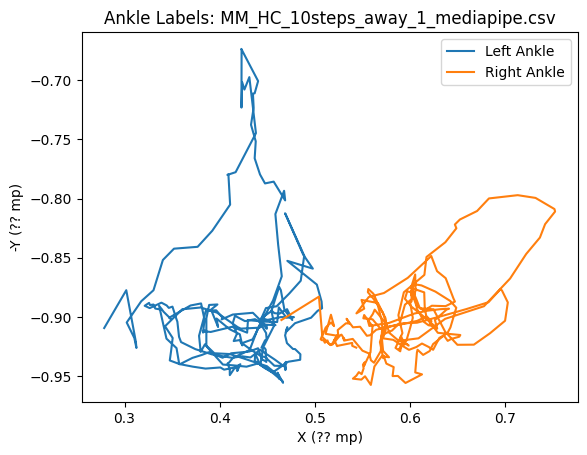

In [8]:
# plot XY position
plt.plot(ank_l_df['X'], -ank_l_df['Y'], label = 'Left Ankle')
plt.plot(ank_r_df['X'], -ank_r_df['Y'], label = 'Right Ankle')

plt.xlabel("X (?? mp)")
plt.ylabel("-Y (?? mp)")
plt.legend(loc = 'best')
plt.title('Ankle Labels: ' + os.path.basename(input_csv))

Text(0.5, 1.0, 'Ankle Labels: MM_HC_10steps_away_1_mediapipe.csv')

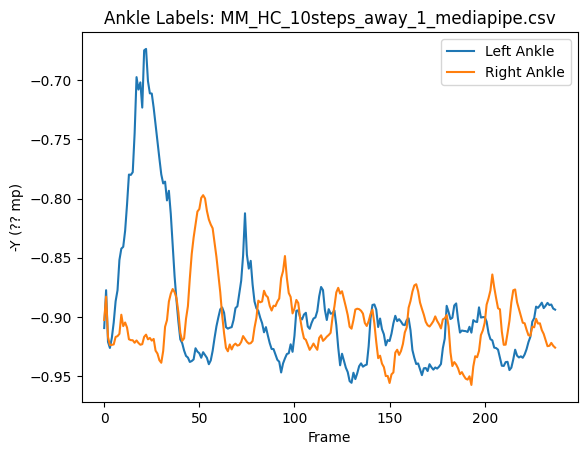

In [9]:
# plot Y vs frames 
plt.plot(ank_l_df['frame'], -ank_l_df['Y'], label = 'Left Ankle')
plt.plot(ank_r_df['frame'], -ank_r_df['Y'], label = 'Right Ankle')


plt.xlabel("Frame")
plt.ylabel("-Y (?? mp)")
plt.legend(loc = 'best')
plt.title('Ankle Labels: ' + os.path.basename(input_csv))

In [10]:
# subtract difference between Y l and r ankle position 

# set frame as index to subtract each frmae 
ank_l_df.index = ank_l_df['frame']
ank_r_df.index = ank_r_df['frame']

In [11]:
ank_l_df.head()

,label_num,X,Y,Z,vis,pres,frame,label,approx_time_sec
frame,,,,,,,,,
0,27,0.278660,0.909302,0.261511,0.972472,0.0,0,left_ankle,0.000000
1,27,0.301841,0.877364,0.945230,0.962698,0.0,1,left_ankle,0.033755
2,27,0.311904,0.920978,0.620625,0.956795,0.0,2,left_ankle,0.067511
3,27,0.312495,0.926136,0.575027,0.955600,0.0,3,left_ankle,0.101266
4,27,0.310326,0.917731,0.557848,0.956958,0.0,4,left_ankle,0.135021


In [12]:
ank_r_df.head()

,label_num,X,Y,Z,vis,pres,frame,label,approx_time_sec
frame,,,,,,,,,
0,28,0.464746,0.902528,0.438003,0.963399,0.0,0,right_ankle,0.000000
1,28,0.504140,0.882791,0.618654,0.958422,0.0,1,right_ankle,0.033755
2,28,0.507728,0.916921,0.560351,0.953879,0.0,2,right_ankle,0.067511
3,28,0.516477,0.923729,0.566830,0.952318,0.0,3,right_ankle,0.101266
4,28,0.516509,0.923513,0.629988,0.952985,0.0,4,right_ankle,0.135021


## To- do 
optimize rolling window - 15 works best here, stenum paper = 10 

In [13]:
# difference between Y values of left and right ankles 
# min and max of this plot are gait events 

# 2 = Y column 
ank_y_diff_0 = ank_l_df.iloc[:,2] - ank_r_df.iloc[:,2]

# moving mean of Y difference - Stenum et al paper window = 10
ank_y_diff = pd.Series(ank_y_diff_0).rolling(window=15, min_periods=1).mean()


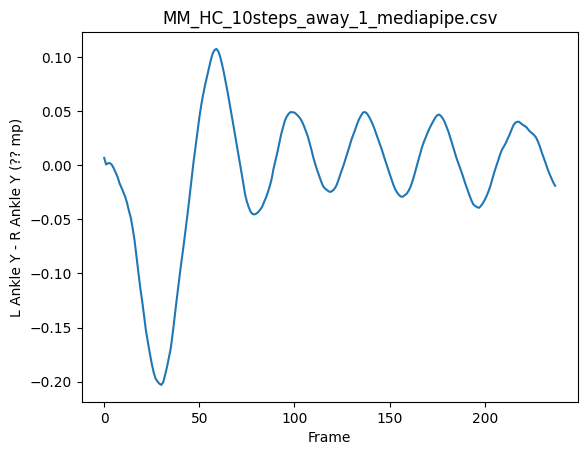

In [14]:
# plot 
plt.plot(ank_l_df['frame'], ank_y_diff)
plt.xlabel("Frame")
plt.ylabel("L Ankle Y - R Ankle Y (?? mp)")
plt.title(os.path.basename(input_csv))
plt.show()

In [15]:
# find index of local minimum and maximum of distance between right and left ankle  
ank_y_diff_peaks_byFrame, _ = find_peaks(ank_y_diff)
ank_y_diff_valleys_byFrame, _ = find_peaks(-ank_y_diff)

# divide by Hz to get position of peaks in seconds, use for plots below 
ank_y_diff_peaks_bySecond = ank_y_diff_peaks_byFrame/hz
ank_y_diff_valleys_bySecond = ank_y_diff_valleys_byFrame/hz

# Output the local minima and maxima
print("Number of local maxima:", len(ank_y_diff_peaks_bySecond))
print("Number of local minima:", len(ank_y_diff_valleys_bySecond))

Number of local maxima: 6
Number of local minima: 6


## To - do 
Why do minimum and maximum markers shift over? Seems accurate at early frames, but later points don't align with plot local max

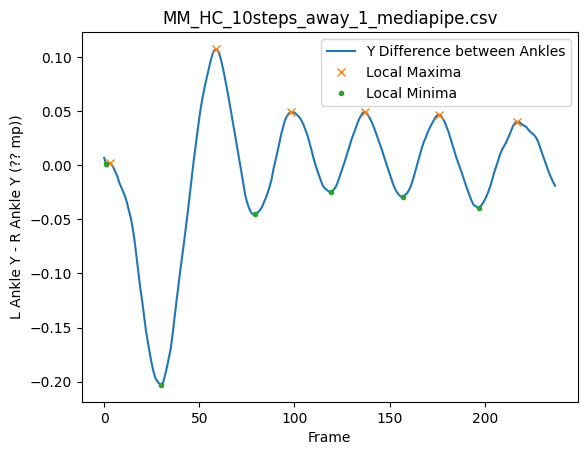

In [16]:
# plot y difference in ankles and add labels on local min and max 
plt.plot(ank_l_df['frame'], ank_y_diff, label='Y Difference between Ankles')
plt.plot(ank_y_diff_peaks_byFrame, ank_y_diff.iloc[ank_y_diff_peaks_byFrame], "x", label='Local Maxima')
plt.plot(ank_y_diff_valleys_byFrame, ank_y_diff.iloc[ank_y_diff_valleys_byFrame], ".", label='Local Minima')
plt.xlabel('Frame')
plt.ylabel("L Ankle Y - R Ankle Y (?? mp))")
plt.legend()
plt.title(os.path.basename(input_csv))
plt.show()


## Stride Time ---------------------------------------------------
PKMAS Definition Stride Time and Gait Cycle Time (listed under Gait Phase Category) use the same computation but both interchangeable measurements are available in PKMAS. The period of time from first contact of one foot, to the following first contact of the same foot (sec).

In [17]:
# Stride time 

# Time between local max - R or L gait event (TBD)
stride_times_peaks = pd.Series(ank_y_diff_peaks_bySecond).diff()
stride_time_peaks_mean = np.mean(stride_times_peaks)
print("Leg 1 (peaks) Mean Stride Time = " + str(round(stride_time_peaks_mean, 2)) + " seconds")

# Time between local min - R or L  gait event (TBD) 
stride_times_valleys = pd.Series(ank_y_diff_valleys_bySecond).diff()
stride_time_valleys_mean = np.mean(stride_times_valleys)
print("Leg 2 (valleys) Mean Stride Time = " + str(round(stride_time_valleys_mean, 2)) + " seconds")

Leg 1 (peaks) Mean Stride Time = 1.44 seconds
Leg 2 (valleys) Mean Stride Time = 1.32 seconds


## Cadence -------------------------------------------------
PKMAS - The number of footfalls minus one divided by the ambulation time, converted to minutes (steps/min). Cadence is shown on the “Mean” row of the Gait Table

In [18]:
# cadence 
total_steps = len(ank_y_diff_peaks_bySecond) + len(ank_y_diff_valleys_bySecond) # peaks + valleys
print(total_steps)
print(video_length_sec) # will need to update based on segments of video 
cadence = (total_steps/video_length_sec) * 60
print("Cadence = " + str(cadence) + " steps/minute")

12
8
Cadence = 90.0 steps/minute


## Step  time ---------------------------------------------------
PKMAS - The period of time taken for one step measured from first contact of one foot to the first contact of following other foot, measured for the stride of which it is the second part (sec).

𝐿𝑒𝑓𝑡 1 𝑆𝑡𝑒𝑝 𝑇𝑖𝑚𝑒=𝐿𝑒𝑓𝑡 2 𝐹𝑖𝑟𝑠𝑡 𝐶𝑜𝑛𝑡𝑎𝑐𝑡−𝑅𝑖𝑔ℎ𝑡 1 𝐹𝑖𝑟𝑠𝑡 𝐶𝑜𝑛𝑡𝑎𝑐𝑡 =10.358−9.775 =0.583 𝑠𝑒𝑐

max(1) time - min(1) time; 
min(1) time - max(2) time 

In [19]:
# Step time calculation 



## stance width -------------------------------------
PKMAS - Stride Width is the perpendicular distance between the line connecting the two ipsilateral foot heel contacts (stride) with the contralateral heel contact between those events (cm).
- don't think we can calculate in same way without z distance in vertical videos. 

Try difference in x value of heels when y difference between heels = 0? Other ideas? 

In [20]:
# stance Width calculation

# single and double support stance -------------
Use some combo of foot and heel markers to know when both feet are on the ground? 

## Total double support % (Mean) 

## Total Double Support % - Ratio - L/R

## Single Support % - Ratio - L/R

## Single Support % - Mean 

# Turns ----------------------------------------
- na for this one, no turns in my 10 step video 

## Steps Per turn 

In [21]:
# steps per turn calculation

## Turn time 